# Object localization - Bounding Box

---



# 1 . 700 annotations of Kumar Sangakkara's face dataset

### 1 .a. Context

Recently I have been working on some object localization problems using Convolutional Nets and I wanted to try train the model on a new dataset other than the very common COCO or PASCAL VOC datasets. While pondering on what object to compile a small dataset around, I thought of pushing the challenge a bit more to see if the same model can be trained to localize faces. Having this in mind I wanted a dataset of a person's face annotations.

As you may know with Deep Learning models, the more data you have the more accuracy you reach. So considering the challenge to detect a face I wanted a considerable number of images of the same face that the model should be trained on.

Hence, I needed many pictures of the same person. So the person had to be famous so I could easily find many pictures.
So being in Sri Lanka where else to look other than our Cricket stars. So I chose the living legend in Sri Lankan Cricket, Kumar Sangakkara.

### 1 .b. Content

I downloaded around 1000 images from google images and after manual cleaning ended up with 704, which are contained here. I manually annotated all the pictures using a python script to generate the xml files. (Yeah, I couldn't find a better thing to do in that 2 hours.) Now here is the dataset for anyone to make use of.


### 1 .c. Inspiration

So as I mentioned in the above description, my goal with this dataset was to see if an object localization model can be used to detect a face of a person. Even though I have the pipeline, I couldn't still thoroughly test its performance using a GPU. So anyone whose interested can use this dataset to test those results.
Also if these annotations can be useful for any other application, feel free to use it and share it.
Have fun!

### 1 .d.  Link to dataset: 

https://www.kaggle.com/mirantha/sangaface/

### 1 .e.  Note: 

For the simplicity of the data, we have convered the .xml format to .csv fomat.In the data set we have images.zip (where we have images as .png files) , train.csv (where we have path, image_height, image_width, x_min, y_min, x_max, y_max ) and validation.csv (where we have path, image_height, image_width, x_min, y_min, x_max, y_max )

# 2 .Load the dataset and Import the packages

### 2 .a. Import the packages

Firstly, let's select TensorFlow version 2.x in colab

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

### 2 .b. Load the dataset

As we are using google colab, we need to mount the google drive to load the data file

In [ ]:
from google.colab import drive
drive.mount('')

Add path to the folder where your dataset files are

In [4]:
project_path = 'D:/'

Let's load the dataset now

In [5]:
images_zip_path = project_path + "images.zip"

from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [6]:
DATASET_FOLDER = "./images/"
TRAIN_CSV = project_path + "train.csv"
VALIDATION_CSV = project_path + "validation.csv"

### 2 .c. Get training data

In [7]:
import numpy as np
import csv

IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224). MobileNetV2 can also take 96

with open(TRAIN_CSV, "r") as f:
  
  y_train = np.zeros((sum(1 for line in f), 4))
  X_train = []
  f.seek(0)
  data = csv.reader(f, delimiter=',')
  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
      if r != '':
        row[i+1] = int(r)
      else :
        row[i+1] = 0
    path, image_height, image_width, x0, y0, x1, y1 = row       # Read image, its dimensions, BBox coords
    path = "./"  + path.split('/')[-3] + "/" + path.split('/')[-2] + "/" + path.split('/')[-1]
    y_train[index, 0] = x0 * IMAGE_SIZE / image_width                 # Normalize bounding box by image size
    y_train[index, 1] = y0 * IMAGE_SIZE / image_height                # Normalize bounding box by image size
    y_train[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width          # Normalize bounding box by image size
    y_train[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height         # Normalize bounding box by image size

    X_train.append(path)                                              # All training images in this list

In [8]:
X_train[:5]

['./Image/Train/000049.png',
 './Image/Train/000043.png',
 './Image/Train/000047.png',
 './Image/Train/000042.png',
 './Image/Train/000048.png']

### 2 .d. Let's check how does the data look like

Fetching coordinates details

In [9]:
import cv2
# Pick a random image to check how it looks
filename = X_train[0]
unscaled = cv2.imread(filename)
region = y_train[0]
image_height, image_width, _ = unscaled.shape
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### 2 .e. Visualize a particular image

Now, let's plot the image and the bounding box on top of it

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

ModuleNotFoundError: No module named 'matplotlib'

# 3 . Process the dataset

### 3 .a. Back to data preparation

In [11]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, f in enumerate(X_train):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_train[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [12]:
X_train = np.array(X_train)

In [13]:
X_train.shape

(668, 128, 128, 3)

In [14]:
y_train

array([[44.38190955, 26.3083004 , 15.43718593, 14.67193676],
       [67.14754098, 25.13454545, 37.07103825, 22.34181818],
       [56.81283422, 15.17037037, 19.85026738, 11.85185185],
       ...,
       [68.84462151, 10.18905473, 22.43824701, 20.37810945],
       [32.96969697, 21.66929134, 53.65656566, 39.81102362],
       [ 0.56888889, 21.71428571, 53.47555556, 85.71428571]])

In [15]:
y_train.shape

(668, 4)

### 3 .b. Data preperation for validation data

In [16]:
with open(VALIDATION_CSV, "r") as f:
  
  y_val = np.zeros((sum(1 for line in f), 4))
  X_val = []
  f.seek(0)
  data = csv.reader(f, delimiter=',')
  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
      if r != '':
        row[i+1] = int(r)
      else :
        row[i+1] = 0
    path, image_height, image_width, x0, y0, x1, y1 = row     # Read image, its dimensions, BBox coords
    path = "./" + path.split('/')[-3] + "/" + path.split('/')[-2] + "/" + path.split('/')[-1]
    y_val[index, 0] = x0 * IMAGE_SIZE / image_width                 # Normalize bounding box by image size
    y_val[index, 1] = y0 * IMAGE_SIZE / image_height                # Normalize bounding box by image size
    y_val[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width          # Normalize bounding box by image size
    y_val[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height         # Normalize bounding box by image size

    X_val.append(path)                                                # All training images in this list

In [17]:
X_val[:5]

['./Image/validation/000000.png',
 './Image/validation/000034.png',
 './Image/validation/000033.png',
 './Image/validation/000031.png',
 './Image/validation/000035.png']

In [18]:
for i, f in enumerate(X_val):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_val[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [19]:
X_val = np.array(X_val)

In [20]:
X_val.shape

(36, 128, 128, 3)

In [21]:
y_val

array([[34.05504587, 14.40692641, 44.62385321, 42.11255411],
       [58.40776699,  7.06748466, 19.46925566, 41.6196319 ],
       [25.6988417 , 15.83505155, 35.08880309, 52.12371134],
       [61.27014218,  6.9623431 , 18.8056872 , 21.958159  ],
       [39.64179104, 26.55319149, 45.37313433, 65.36170213],
       [42.66666667, 21.41090909, 51.75956284, 40.49454545],
       [46.94980695, 17.15463918, 30.64092664, 46.18556701],
       [56.24242424, 24.09411765, 13.57575758, 13.55294118],
       [51.3976834 , 42.88659794, 21.25096525, 31.01030928],
       [63.76727273, 16.78688525, 25.13454545, 36.3715847 ],
       [39.38461538, 28.02366864, 31.67892977, 60.59171598],
       [15.49473684, 16.84210526, 64.        , 52.93233083],
       [52.81118881, 38.54545455, 29.53846154, 61.09090909],
       [67.08433735,  5.05263158, 11.56626506, 30.31578947],
       [23.90041494, 23.27272727, 43.55186722, 56.34449761],
       [38.54826255, 33.64948454, 26.68725869, 42.22680412],
       [97.52380952, 22.

In [22]:
y_val.shape

(36, 4)

# 4 .  Build an Object Localizing model for the dataset

### 4 .a. Create the model

In [23]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name="coords")(x0)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x2)

# 5 . Evaluate this model

### 5 .a. Define evaluation metric

In [24]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [25]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

### 5 .b. Initialize the model and print summary

In [26]:
model = create_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0     

### 5 .c. Compile the model
- loss: "mean_squared_error"
- metrics: IoU
- optimizer: "adam"

In [27]:
# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

# 6 . Train model 2 

### 6 .a. Training the model

Fit the model to the dataset
- Use early stopping
- fit the model
    - give train data - training features and labels
    - batch size: 32
    - epochs: 10
    - give validation data - testing features and labels

In [32]:
# Use earlystopping
import tensorflow 
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[callback])

Epoch 1/10
21/21 [==============================] - 6s 190ms/step - loss: 442.0514 - IoU: 0.2389 - val_loss: 137.0308 - val_IoU: 0.4441
Epoch 2/10
21/21 [==============================] - 3s 162ms/step - loss: 199.6041 - IoU: 0.4032 - val_loss: 70.5372 - val_IoU: 0.5532
Epoch 3/10
21/21 [==============================] - 4s 190ms/step - loss: 142.0412 - IoU: 0.4663 - val_loss: 59.8499 - val_IoU: 0.5793
Epoch 4/10
21/21 [==============================] - 4s 195ms/step - loss: 107.4613 - IoU: 0.5109 - val_loss: 60.4386 - val_IoU: 0.6090
Epoch 5/10
21/21 [==============================] - 3s 160ms/step - loss: 82.0932 - IoU: 0.5586 - val_loss: 53.0976 - val_IoU: 0.6481
Epoch 6/10
21/21 [==============================] - 3s 153ms/step - loss: 65.2798 - IoU: 0.5967 - val_loss: 54.2078 - val_IoU: 0.6541


# 7 . Evaluate this model

### 7 .a. Final loss and accuracy

In [33]:
model.evaluate(X_val, y_val)

2/2 [==============================] - 0s 37ms/step - loss: 54.2078 - IoU: 0.6541


[54.20780563354492, 0.6541000008583069]

### 7 .b. Model evaluation on Validation data

#### 7 .b.i. Test the model on an image from validation data

In [34]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
filename = './Image/validation/000022.png'

unscaled = cv2.imread(filename) # Original image for display

In [35]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
print ("Size of original input: ", image.shape)
print("-------------------------------")
print("Size of scaled input: ", feat_scaled.shape)

Size of original input:  (128, 128, 3)
-------------------------------
Size of scaled input:  (128, 128, 3)


In [36]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

#### 7 .b.ii. Fetching coordinates details from predicted result

In [37]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

#### 7 .b.iii. Now, let's plot the image and the bounding box on top of it

In [38]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

NameError: name 'plt' is not defined

### 7 .c. Model evaluation on 2nd Validation data

#### 7 .c.i. Test the model on second image from validation data

In [39]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
filename = './Image/validation/000007.png'

unscaled = cv2.imread(filename) # Original image for display

In [40]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [41]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

#### 7 .c.ii. Fetching coordinates details

In [42]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

#### 7 .c.iii. Now, let's plot the second image and the bounding box on top of it

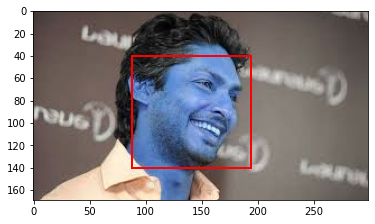

In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()